In [325]:
import numpy as np
import re
import os
from matplotlib import pyplot as plt
from scipy.linalg import svdvals, svd

def read_epwdata_fmt(fmt_file):
    """
    Reads H (Hamiltonian), D (Dynamical Matrix), and G (El-Ph Matrix)
    """
    print(f"Reading Text Data: {fmt_file}")
    with open(fmt_file, 'r') as f:
        raw = f.read() #string containing all the file RN!

    # 1. Parse Dimensions from Header
    # Remove complex (x,y), care later
    header = re.sub(r'\([^)]+\)', '', raw).split()
    #print(header)
    
    # Map based on epw_write source code
    ef = float(header[0])
    nbnd   = int(header[1])
    nrr_k = int(header[2]) # Electronic grid size
    nmodes = int(header[3])
    nrr_q = int(header[4]) # Phonon grsorted_id size
    nrr_g = int(header[5]) # El-Ph grsorted_id size (usually same as nrws_q)

    print(f"Dims: Bands={nbnd}, Modes={nmodes}, R_k={nrr_k}, R_g={nrr_g}, R_q={nrr_q}")

    # 2. Parse H and D (Text)
    # Find all (Real, Imag) pairs
    # Matsches all sequence in the form ( + any space [numbers . -+ E any space] , [numbers . -+ E any space] any space)
    # NB * is important because says any number including 0!
    # + says that we want to find one of more character in the group [ ]
    # () arounf []+ capture the entire group, so that matches becomes a tuple of captured element
    # with no ([...]+)  and only [] i capture the whole string '(...,...)'
    matches = re.findall(r'\(\s*([0-9.\-\+E]+)\s*,\s*([0-9.\-\+E]+)\s*\)', raw)
    #print(matches)
    data_complex = np.array([complex(float(r), float(i)) for r, i in matches])
        
    # H = H[Re,i,j]
    d = 0 #d index
    H = np.zeros((nrr_k,nbnd,nbnd),dtype=complex)
    for i in range(nbnd):
        for j in range(nbnd):
            for R in range(nrr_k):
                H[R,i,j] = data_complex[d]
                d+=1
    
    # D = H[Rp,a,b]
    D = np.zeros((nrr_q,nmodes,nmodes),dtype=complex)
    for a in range(nmodes):
        for b in range(nmodes):
            for Rp in range(nrr_q):
                D[Rp,a,b] = data_complex[d]
                d+=1
    
    if(d == data_complex.shape[0]):
        print("!All the file has been red!")
    else:
        print("WARNING: some lines are missing", data_complex.shape[0],d)
    return H,D,ef ,nbnd, nrr_k, nmodes, nrr_q, nrr_g
H,D,ef ,nbnd, nrr_k, nmodes, nrr_q, nrr_g = read_epwdata_fmt('../DATA/epwdata.fmt', )



Reading Text Data: ../DATA/epwdata.fmt
Dims: Bands=4, Modes=6, R_k=279, R_g=279, R_q=279
!All the file has been red!


In [326]:
NK = [6,6,6]  
alat = 10.26    # Lattice param (Bohr) - from scf.in
# FCC Lattice vectors
at = (alat / 2.0) * np.array([[-1., 0., 1.], [0., 1., 1.], [-1., 1., 0.]]).T

# REPLICATE WIGNER.F90 LOOP ORDER
def generate_raw_scan_order(nk, at):
    print("Replicating wigner.f90 scan loops...")
    
    # Metric tensors for distance check
    T_metric = np.zeros((3,3))
    for i in range(3):
        T_metric[:, i] = at[:, i] * nk[i]

    # The list that will hold the vectors IN THE ORDER THEY ARE FOUND
    found_vectors = []
    
    # EPW Scan Range: -2*N to +2*N (Lines 218-220 in wigner.f90)
    # Crucial: The loops are n1 (outer), n2, n3 (inner)
    
    range_1 = range(-2 * nk[0], 2 * nk[0] + 1)
    range_2 = range(-2 * nk[1], 2 * nk[1] + 1)
    range_3 = range(-2 * nk[2], 2 * nk[2] + 1)

    for n1 in range_1:
        for n2 in range_2:
            for n3 in range_3:
                
                # 1. Calculate Distance of current point R
                R = n1*at[:,0] + n2*at[:,1] + n3*at[:,2]
                dist_R = np.linalg.norm(R)
                
                # 2. Wigner-Seitz Check (Is it the closest image?)
                # We check against 125 supercell neighbors
                is_in_ws = True
                
                # Optimization: Check origin image immediately to save time
                # If dist_R is huge, it's likely not in WS
                
                for i1 in range(-2, 3):
                    for i2 in range(-2, 3):
                        for i3 in range(-2, 3):
                            if i1==0 and i2==0 and i3==0: continue
                            
                            T = i1*T_metric[:,0] + i2*T_metric[:,1] + i3*T_metric[:,2]
                            dist_img = np.linalg.norm(R - T)
                            
                            if dist_img < dist_R - 1e-4:
                                is_in_ws = False
                                break # Not a WS point
                    if not is_in_ws: break
                
                # 3. If valsorted_id, APPEND to list (NO SORTING)
                if is_in_ws:
                    found_vectors.append( (n1*at[:,0] + n2*at[:,1]+ n3*at[:,2]) )

    return np.array(found_vectors) 
R = generate_raw_scan_order(NK, at)

print(f"\nTotal vectors found: {len(R)} (Should be {nrr_k})")


Replicating wigner.f90 scan loops...

Total vectors found: 279 (Should be 279)


(279, 4, 4)


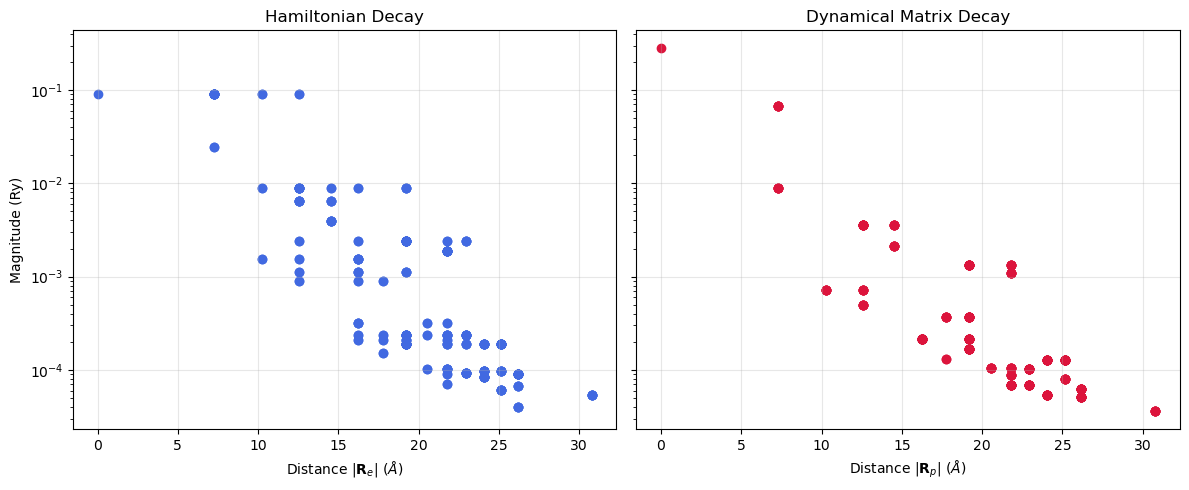

In [327]:
dist = np.linalg.norm(R, axis=1)
sorted_id = np.argsort(dist)
R_sort = R[sorted_id]
dist = dist[sorted_id]
H_sort = H[sorted_id]
D_sort = D[sorted_id]
print(H.shape)

values_H = np.array([np.max(np.abs(H_sort[i,...]))for i in range(H_sort.shape[0])])
values_D = np.array([np.max(np.abs(D_sort[i,...]))for i in range(D_sort.shape[0])])

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Electronic
ax[0].scatter(dist, values_H, color='royalblue', lw=1)
ax[0].set_title("Hamiltonian Decay")
ax[0].set_xlabel(r"Distance $|\mathbf{R}_e|$ ($\AA$)")
ax[0].set_ylabel("Magnitude (Ry)")
ax[0].grid(True, alpha=0.3)

# Phonetic
ax[1].scatter(dist, values_D, color='crimson', lw=1)
ax[1].set_title("Dynamical Matrix Decay")
ax[1].set_xlabel(r"Distance $|\mathbf{R}_p|$ ($\AA$)")
ax[1].grid(True, alpha=0.3)

plt.yscale("log")
plt.tight_layout()
plt.show()


Reading ../DATA/silicon.epmatwp...
G shape loaded: (279, 279, 6, 4, 4)


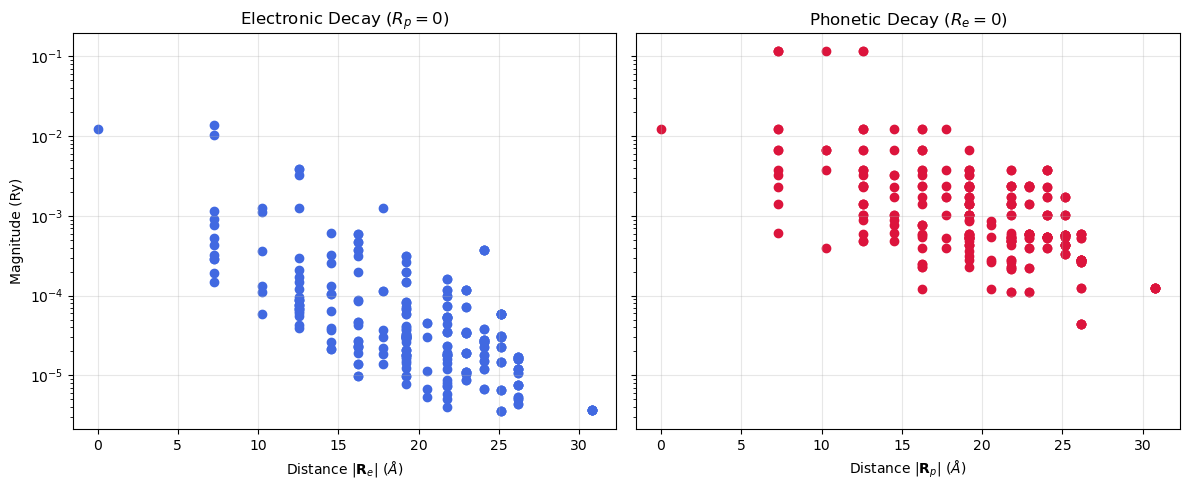

In [328]:
def read_epmatwp(bin_file, nbnd, nrr_k, nmodes, nrr_g,R,PLOT=False):
    print(f"Reading {bin_file}...")

    # 1. Read Raw Bytes
    # Complex128 = 16 bytes per number
    G_raw = np.fromfile(bin_file, dtype=np.complex128)

    # 2. Reshape 
    # Fortran Order: (Band, Band, Re, Mode, Rp)
    G_ftn = G_raw.reshape((nbnd, nbnd, nrr_k, nmodes, nrr_g), order='F')

    # 3. Transpose to Python Logic
    # New Order: (Re, Rp, Mode, Band, Band)
    G = G_ftn.transpose(2, 4, 3, 0, 1)
    dist_G = np.linalg.norm(R, axis=1)
    sorted_id = np.argsort(dist_G)
    dist_sorted = dist_G[sorted_id]
    G_sort = G[sorted_id]
    G_sort = G_sort[:, sorted_id]
    print(f"G shape loaded: {G.shape}")
    if(PLOT):
        
        # Case A: Electronic Decay (Phonon fixed at R=0)
        # We look at G[0, :, :, :, :] -> varies with Re
        G_el = G_sort[:, 0, :, :, :]
        decay_el = np.array([np.max(np.abs(G_el[i,...]))for i in range(G_el.shape[0])])
        # Case B: Phonetic Decay (Electron fixed at R=0)
        # We look at G[:, 0, :, :, :] -> varies with Rp
        G_ph = G_sort[ 0,:, :, :, :]
        decay_ph = np.array([np.max(np.abs(G_ph[i,...]))for i in range(G_ph.shape[0])])

        fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        # Electronic
        ax[0].scatter(dist_sorted, decay_el, color='royalblue', lw=1)
        ax[0].set_title(r"Electronic Decay ($R_p=0$)")
        ax[0].set_xlabel(r"Distance $|\mathbf{R}_e|$ ($\AA$)")
        ax[0].set_ylabel("Magnitude (Ry)")
        ax[0].grid(True, alpha=0.3)

        # Phonetic
        ax[1].scatter(dist_sorted, decay_ph, color='crimson', lw=1)
        ax[1].set_title(r"Phonetic Decay ($R_e=0$)")
        ax[1].set_xlabel(r"Distance $|\mathbf{R}_p|$ ($\AA$)")
        ax[1].grid(True, alpha=0.3)

        plt.yscale("log")
        plt.tight_layout()
        plt.show()
    return G,G_sort

G,G_sort = read_epmatwp("../DATA/silicon.epmatwp",nbnd, nrr_k, nmodes, nrr_g,R,PLOT=True)

In [329]:
import numpy as np
from scipy.io import FortranFile

def read_epb_mixed_record(filename, nkc, nbnd, nmodes, nat):
    """
    Reads a mixed-type EPW .epb file written as a single record.
    
    Structure:
      nqc      (int32)
      xqc      (3, nqc) float64
      et_loc   (nbnd, nkc) float64
      dynq     (nmodes, nmodes, nqc) complex128
      epmatq   (nbnd, nbnd, nmodes, nkc, nqc) complex128
      zstar    (3, 3, nat) float64
      epsi     (3, 3) float64
    """
    print(f"Reading {filename}...")
    
    # 1. Read the full record as raw bytes
    f = FortranFile(filename, 'r')
    # Read everything as bytes (int8/byte)
    raw_bytes = f.read_record(dtype=np.byte)
    f.close()
    
    print(f"  - Total Record Bytes: {raw_bytes.size}")
    
    # 2. Setup a buffer iterator
    # We use offsets to slice the buffer
    offset = 0
    
    # Helper to read chunk
    def read_chunk(dtype, count):
        nonlocal offset
        item_size = np.dtype(dtype).itemsize
        total_bytes = count * item_size
        
        # Extract bytes
        chunk_bytes = raw_bytes[offset : offset + total_bytes]
        offset += total_bytes
        
        # Cast to correct type
        data = np.frombuffer(chunk_bytes, dtype=dtype)
        
        if data.size != count:
            raise ValueError(f"Read error: expected {count} items, got {data.size}")
        return data

    # --- A. Read nqc ---
    nqc_arr = read_chunk(np.int32, 1)
    nqc = nqc_arr[0]
    print(f"  - nqc (q-points in file): {nqc}")
    
    # --- B. Read xqc ---
    # Shape: (3, nqc)
    xqc = read_chunk(np.float64, 3 * nqc).reshape((3, nqc), order='F')
    
    # --- C. Read et_loc (Eigenvalues) ---
    # Shape: (nbnd, nkc)
    et_loc = read_chunk(np.float64, nbnd * nkc).reshape((nbnd, nkc), order='F')
    
    # --- D. Read dynq (Dynamical Matrix) ---
    # Shape: (nmodes, nmodes, nqc)  where nmodes = 3*nat
    dynq = read_chunk(np.complex128, nmodes * nmodes * nqc).reshape((nmodes, nmodes, nqc), order='F')
    
    # --- E. Read epmatq (El-Ph Matrix) ---
    # Fortran Shape: (nbnd, nbnd, nmodes, nkc, nqc)
    # This is the massive array
    epmatq_size = nbnd * nbnd * nmodes * nkc * nqc
    print(f"  - Reading epmatq ({epmatq_size} complex elements)...")
    
    epmatq_flat = read_chunk(np.complex128, epmatq_size)
    epmatq_ftn = epmatq_flat.reshape((nbnd, nbnd, nmodes, nkc, nqc), order='F')
    
    # Transpose to Python friendly: (nqc, nkc, nmodes, nbnd, nbnd)
    # (4, 3, 2, 0, 1)
    epmatq = epmatq_ftn.transpose(4, 3, 2, 0, 1)
    
    
    # Check if we consumed all bytes
    remaining = raw_bytes.size - offset
    if remaining != 0:
        print(f"  ! Warning: {remaining} bytes remaining in record (padding?).")
    else:
        print("  - Successfully read all bytes.")
        
    return {
        'nqc': nqc,
        'xqc': xqc,
        'et': et_loc,
        'dyn': dynq,
        'epmat': epmatq
    }
# Constants for Silicon
nkc = 216  # 6x6x6
nbnd = 4
nmodes = 6
nat = 2

try:
    data = read_epb_mixed_record(
        '../DATA/silicon.epb1', 
        nkc, nbnd, nmodes, nat
    )
    
    G_bloch = data['epmat']
    Q_list = data['xqc'].T
    
    print(f"Loaded G_bloch shape: {G_bloch.shape}")
    # Expected: (216, 216, 6, 4, 4)
    print(Q_list.shape)

except Exception as e:
    print(f"Error: {e}")

Reading ../DATA/silicon.epb1...
  - Total Record Bytes: 71800348
  - nqc (q-points in file): 216
  - Reading epmatq (4478976 complex elements)...
  ! Warning: 216 bytes remaining in record (padding?).
Loaded G_bloch shape: (216, 216, 6, 4, 4)
(216, 3)


In [330]:
def svd_trend(matrix,nBand_1,nBand_2,nBand_ph ,second = False, matrix2 = np.empty(0),name=""):
    rmax = min(matrix.shape[0], matrix.shape[1])
    print(rmax)
    rel_error = np.zeros(rmax, dtype=float)
    frob = 0.0

    for m in range(nBand_1):
        for n in range(nBand_2):
            for v in range(nBand_ph):
                g_kq = matrix[ :, : ,v, n,m]
                s = svdvals(g_kq)
                if s.size < rmax:
                    s = np.pad(s, (0, rmax - s.size))
                else:
                    s = s[:rmax]
                s_2 = s**2
                frob += s_2.sum()
                for k in range(rmax):
                    rel_error[k] += s_2[k:].sum()

    rel_error = (rel_error / frob)

    if (second):
        rmax2 = min(matrix2.shape[0], matrix2.shape[1])
        rel_error2 = np.zeros(rmax, dtype=float)
        frob2 = 0.0

        for m in range(nBand_1):
            for n in range(nBand_2):
                for v in range(nBand_ph):
                    g_kq2 = matrix2[ :, :, v, n, m]
                    s2 = svdvals(g_kq2)
                    if s2.size < rmax2:
                        s2 = np.pad(s2, (0, rmax2 - s2.size))
                    else:
                        s2 = s2[:rmax2]
                    s_2 = s2**2
                    frob2 += s_2.sum()
                    for k in range(rmax):
                        rel_error2[k] += s_2[k:].sum()

        rel_error2 = (rel_error2 / frob2)
    x_percent = np.arange(1, rmax + 1) / rmax * 100
    return rel_error,x_percent

rel_error, x_percent = svd_trend(G,nbnd,nbnd,nmodes)
rel_error_k,x_perc_k = svd_trend(G_bloch,nbnd,nbnd,nmodes)







279
216


In [331]:
def SVD(matrix,nBand_n,nBand_m,nBand_ph ,name="",SVlist = np.empty(0), PLOT=False):
    rmax = min(matrix.shape[0], matrix.shape[1])
    U = np.zeros((matrix.shape[0],rmax,nBand_ph,nBand_n,nBand_m),dtype="complex")
    Vt = np.zeros((rmax,matrix.shape[1],nBand_ph,nBand_n,nBand_m) ,dtype="complex")
    s = np.zeros((rmax,nBand_ph,nBand_n,nBand_m),dtype="complex")

    for m in range(nBand_m):
        for n in range(nBand_n):
            for v in range(nBand_ph):
                U[...,v,n,m],s[...,v,n,m],Vt[...,v,n,m] = svd(matrix[...,v,n,m],full_matrices=False)

    if PLOT:
        pad = [(0,0)]*s.ndim
        results = np.zeros(rmax)
        norm = np.sum(np.abs(matrix)**2)
        gi = np.zeros(matrix.shape)
        for i in range(rmax):
            pad[0] = (0,rmax - i -1 )
            s_red = np.pad(s[:i+1], pad)
            #print(s_red[...,2,3,4])
            gi = np.einsum("rvnm,irvnm,rkvnm -> ikvnm",s_red,U,Vt)
            results[i] =  np.sum(np.abs(matrix-gi)**2)/norm
        
        plt.figure()
        plt.plot(np.arange(rmax)/rmax*100, results)
    
    return U,s,Vt



    


U,s,Vt = SVD(G_sort,nbnd,nbnd,nmodes,PLOT=False)
U_k,s_k,Vt_k = SVD(G_bloch,nbnd,nbnd,nmodes,PLOT=False)




(279,)


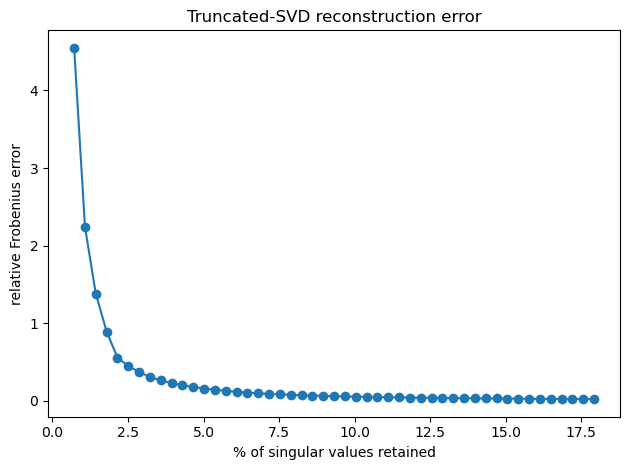

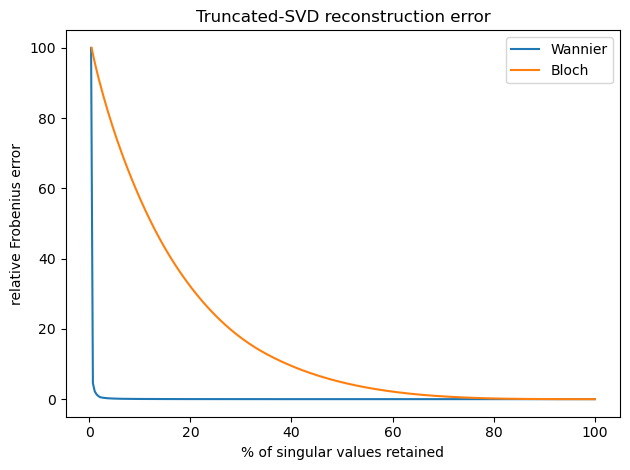

(216,)


In [332]:
def getLowRank2(U,s,Vt,rank):
    if(rank>s.shape[0]):
        print("non valid rank")
        return
    pad = [(0,0)]*s.ndim
    rmax = s.shape[0]
    pad[0] = (0,rmax - rank )
    s_red = np.pad(s[:rank], pad)
    print(s_red.shape,U.shape,Vt.shape)
    return  np.einsum("rvnm,irvnm,rkvnm -> ikvnm",s_red,U,Vt)
print(x_percent.shape)
plt.figure()

plt.plot(x_percent[1:50], rel_error[1:50]*100,"o-", label="unit-cell")

plt.xlabel("% of singular values retained")
plt.ylabel("relative Frobenius error")
plt.title("Truncated-SVD reconstruction error")
plt.tight_layout()
plt.show()

plt.figure()

plt.plot(x_percent[:], rel_error*100, label="Wannier")
plt.plot(x_perc_k, rel_error_k*100, label="Bloch")
plt.xlabel("% of singular values retained")
plt.ylabel("relative Frobenius error")
plt.legend()
plt.title("Truncated-SVD reconstruction error")
plt.tight_layout()
plt.show()
print(x_perc_k.shape)

LR factorization: 0.7250769138336182 seconds 
Relative error with 4% SV = 0.201%
LR factorization: 0.35567808151245117 seconds 
Relative error with 4% SV = 73.6%


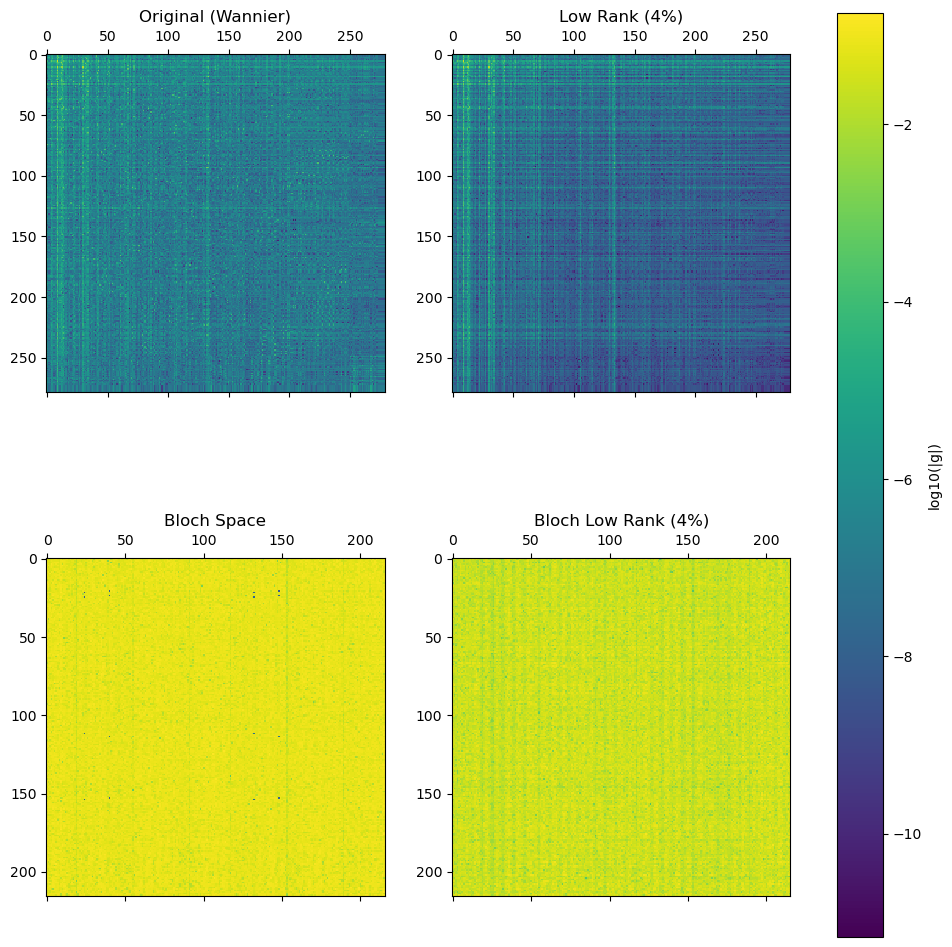

In [333]:
import time
#If rank <=0 gives the full matrix
def getLowRank(U,s,Vt,rank = 0):
    #NB Vt has singular vectors as rows and U as columns
    if(rank<=0):
        rank = s.shape[0]
    if(rank>s.shape[0]):
        print("non valid rank")
        return
    s_red = s[:rank]
    U_red = U[:,:rank,...]
    Vt_red = Vt[:rank,...] 
    return  np.einsum("rvnm,irvnm,rkvnm -> ikvnm",s_red,U_red,Vt_red)


G_abs = np.abs(G_sort)
perc = 4
rank = int(nrr_k * perc / 100)

# Calculate Low Rank Approximation
start_time = time.time()
G_LR2 = getLowRank(U, s, Vt, rank)
print("LR factorization: %s seconds " % (time.time() - start_time))


# Calculate Error
diff = np.abs(G_LR2 - G_sort)**2
relative_error = np.sum(diff) / np.sum(G_abs**2)
print(f"Relative error with {perc}% SV = {relative_error*100:0.3}%")

start_time = time.time()
G_LR2_k = getLowRank(U_k, s_k, Vt_k, rank)
print("LR factorization: %s seconds " % (time.time() - start_time))


# Calculate Error
diff = np.abs(G_LR2_k - G_bloch)**2
relative_error = np.sum(diff) / np.sum(np.abs(G_bloch)**2)
print(f"Relative error with {perc}% SV = {relative_error*100:0.3}%")


# --- PLOTTING FIX ---

# 1. Pre-calculate the log10 data slices
# Adding a tiny epsilon (1e-16) prevents log(0) errors
slice_orig = np.log10(np.abs(G_sort[..., 4, 2, 0]) + 1e-16)
slice_lr   = np.log10(np.abs(G_LR2[..., 4, 2, 0]) + 1e-16)
slice_bloch = np.log10(np.abs(G_bloch[..., 4, 2, 0]) + 1e-16)
slice_lr_bloch   = np.log10(np.abs(G_LR2_k[..., 4, 2, 0]) + 1e-16)

# 2. Determine Global Min/Max for the Color Scale
# This ensures all plots use the exact same color mapping
global_min = min(slice_orig.min(), slice_lr.min(), slice_bloch.min(),slice_lr_bloch.min())
global_max = max(slice_orig.max(), slice_lr.max(), slice_bloch.max(),slice_lr_bloch.max())

# 3. Plot using vmin and vmax
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot Original
im1 = axes[0][0].matshow(slice_orig, vmin=global_min, vmax=global_max)
axes[0][0].set_title("Original (Wannier)")

# Plot Low Rank
im2 = axes[0][1].matshow(slice_lr, vmin=global_min, vmax=global_max)
axes[0][1].set_title(f"Low Rank ({perc}%)")

# Plot Bloch (if dimensions match)
im3 = axes[1][0].matshow(slice_bloch, vmin=global_min, vmax=global_max)
axes[1][0].set_title("Bloch Space")

im3 = axes[1][1].matshow(slice_lr_bloch, vmin=global_min, vmax=global_max)
axes[1][1].set_title(f"Bloch Low Rank ({perc}%)")

# Add a single shared colorbar
fig.colorbar(im1, ax=axes.ravel().tolist(), label="log10(|g|)")

plt.show()

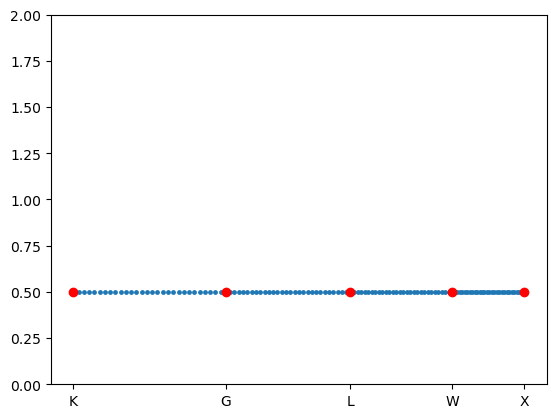

In [334]:

# Constants
RY_TO_EV    = 13.605698066
BOHR_TO_ANG = 0.52917721
AMASS_AMU   = 28.0855 # Silicon Mass
MASS_AU     = AMASS_AMU * 1822.888 # Electron mass units

G = np.array([0,0,0]) #gamma 
L = np.array([0.5,0.5,0.5])
X = np.array([0.5, 0.0, 0.5])
K = np.array([0.375, 0.3750, 0.75])
W = np.array([ 0.5000000000,0.2500000000,0.7500000000])
path = np.array([[K,G],[G,L],[L,W],[W,X]])
xticks_labels = ['K','G','L','W','X']


def get_reciprocal_lattice(A):
    """Computes b_vectors such that a_i . b_j = 2pi delta_ij"""
    # 'A' columns are a1, a2, a3. 
    # b_matrix columns will be b1, b2, b3
    # b_matrix = 2pi * (at^-1).T
    return 2 * np.pi * np.linalg.inv(A).T

import numpy as np

def build_path_and_ticks(b_lat, path, steps=30):
    """
    b_lat : (3,3) reciprocal-lattice matrix (columns = b1,b2,b3)
    path  : array-like of shape (n_seg,2,3) with fractional endpoints in crystal coords
    steps : points per segment (including both ends)
    Returns:
      q_cart   : (N,3) Cartesian q points (1/Bohr)
      x_axis   : (N,) accumulated Cartesian distance
      xticks   : list of positions along x_axis where segment endpoints lie (length = n_seg+1)
    """
    # Build full path in fractional coordinates, avoid duplicating segment endpoints
    full_frac = []
    seg_endpoint_indices = []
    idx = 0
    for iseg, (a_frac, b_frac) in enumerate(path):
        seg = np.linspace(a_frac, b_frac, steps)  # includes both endpoints
        if iseg == 0:
            full_frac.extend(seg.tolist())
            idx += seg.shape[0]
            seg_endpoint_indices.append(idx - 1)
        else:
            seg = seg[1:]               # drop duplicate start point
            full_frac.extend(seg.tolist())
            idx += seg.shape[0]
            seg_endpoint_indices.append(idx - 1)

    full_frac = np.array(full_frac)               # (N,3)
    q_cart = (b_lat @ full_frac.T).T              # (N,3) Cartesian q

    # accumulate Cartesian distances
    x_axis = np.zeros(q_cart.shape[0], dtype=float)
    for i in range(1, q_cart.shape[0]):
        x_axis[i] = x_axis[i-1] + np.linalg.norm(q_cart[i] - q_cart[i-1])

    # xticks positions: start (0.0) and each segment endpoint
    xticks = [0.0] + [float(x_axis[idx]) for idx in seg_endpoint_indices]

    return q_cart, x_axis, xticks

b_lat = get_reciprocal_lattice(at)
q_points, x_axis, xticks_positions = build_path_and_ticks(b_lat, path, steps=30)

fig, ax = plt.subplots()
ax.scatter(x_axis, np.ones_like(x_axis)*0.5, s=6)
ax.scatter(xticks_positions, np.ones(len(xticks_positions))*0.5, color='red')
ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels)
ax.set_ylim(0,2)
plt.show()


(279, 4, 4)


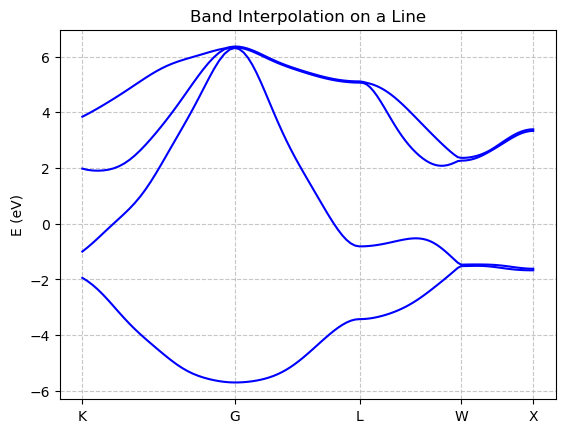

In [335]:
# K can either be a single k point or a collection with shape (n_R , 3)
def check_Hermitian(A):
    A_H = np.conjugate(A).transpose(0,2,1) # each A[k] is a matrix to check actually
    diff = np.abs(A_H -A)
    print("Max: ",np.max(diff)/np.max(np.abs(A)))
    print("Mean: ",np.mean(diff)/np.max(np.abs(A)))
print(H.shape)

def diagonalize_Hw(H_w):
    """
    H_w: (n_orb, n_orb) or (n_k, n_orb, n_orb) hermitian complex array
    Returns:
      evals: shape (n_orb,) or (n_k, n_orb) (real)
      U:     shape (n_orb, n_orb) or (n_k, n_orb, n_orb)  (columns are eigenvectors)
    """
    if H_w.ndim == 2:
        # single k
        evals, U_wan = np.linalg.eigh(H_w)
        return evals, U_wan
    elif H_w.ndim == 3:
        # batched: numpy supports stacked eigh
        evals, U_wan = np.linalg.eigh(H_w)   # evals: (n_k, n_orb), U: (n_k, n_orb, n_orb)
        return evals, U_wan

def interpolate_H(H_wan, K ,R, plotBand = False):
    exp1 = np.exp(1j* K @ R.T)
    if(K.ndim==1): 
        n_kp = 1
        exp1 = exp1.reshape(1,-1)
        
    else:
        n_kp = K.shape[0]
    H_w = np.einsum("kR, Rij -> kij",exp1,H_wan,optimize=True)
    #make the matrix for each k hermitian:
    H_w = 0.5*(H_w + H_w.conj().transpose(0,2,1))
    evals,U_wan = diagonalize_Hw(H_w)
    return evals*RY_TO_EV,U_wan
    

evals, U_wan = interpolate_H(H_sort, q_points, R_sort)


plt.figure()
ax = plt.gca()

for i in range(4):
    ax.plot(x_axis, evals[:, i],color="Blue")

ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Band Interpolation on a Line")
plt.ylabel("E (eV)")
plt.show()


(279, 6, 6)


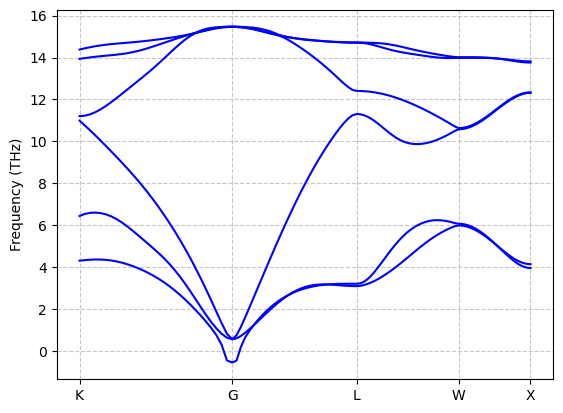

In [336]:
ry_to_thz = 3289.84498
# Silicon Mass in Ry units = AMU * (Mass_Electron_AU / 2) 
# 28.0855 * 911.444 = 25598.3
mass_factor = 25598.3 

#Gives frequencies in Thz (no 2*pi)
def get_frequencies(w_squared):
    sign = np.sign(w_squared)
    w_abs = np.abs(w_squared)
    w_ry = np.sqrt(w_abs) * sign
    freqs = w_ry * ry_to_thz
    return freqs

def diagonalize_Dw(D_w):
    if D_w.ndim == 2:
        w2, e = np.linalg.eigh(D_w)
        return w2, e
    elif D_w.ndim == 3:
        w2, e = np.linalg.eigh(D_w)
        return w2, e

def interpolate_D(D_wan, K ,R, plotBand = False):
    exp1 = np.exp(1j* K @ R.T)
    if(K.ndim==1): 
        n_kp = 1
        exp1 = exp1.reshape(1,-1)
    else:
        n_kp = K.shape[0]
        
    D_w = np.einsum("kR, Rij -> kij",exp1,D_wan,optimize=True)
    
    # Apply Mass Division (Force Constants -> Dynamical Matrix)
    D_w /= mass_factor
    
    D_w = 0.5*(D_w + D_w.conj().transpose(0,2,1))
    
    # Corrected function call name from Hw to Dw
    w2,e = diagonalize_Dw(D_w)
    w = get_frequencies(w2)
    return w,e
    
print(D_sort.shape)
#NB the eigenvector are organized as follow
# index 0 -> n_kp
# index 1 -> is the atomic + cartesian index
# index 2 -> is the mode index
w , e = interpolate_D(D_sort, q_points, R_sort)

plt.figure()
ax = plt.gca()

for i in range(nmodes):
    ax.plot(x_axis, w[:, i], color="blue")

ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels)
ax.set_ylabel("Frequency (THz)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [337]:
# Interpolate G

# Get the fourier transform of left and right SV at specific k and q points
#k and q can either be a single k-point or a list (n_kp,3)
def fourier_transform(U,Vt,q,k,R):
    exp_k = np.exp( 1j * k @ R.T)
    if(k.ndim==1): exp_k = exp_k.reshape(1,-1)

    exp_q = np.exp(1j* q @ R.T)
    if(q.ndim==1): exp_q = exp_q.reshape(1,-1)

    U_k = np.einsum("kR, Rrvij -> krvij", exp_k, U,optimize = True)
    print("Left SV matrix shape:",U_k.shape)
    Vt_q = np.einsum("qR, rRvij -> rqvij", exp_q, Vt,optimize = True)
    print("Right SV matrix shape:", Vt_q.shape)

    return U_k,Vt_q

U_k,Vt_q = fourier_transform(U,Vt,q_points,np.array([0.0,0.0,0.0]).T,R_sort)
rank = int(0.02*s.shape[0])
#To obtain the FT g we can simply use getLowRank on the transformed matrix:
U_k2,Vt_q2 = fourier_transform(U[:,:rank],Vt[:rank],q_points,np.array([0.0,0.0,0.0]).T,R_sort)
g_full_kq = getLowRank(U_k,s,Vt_q)
s2 = s[:rank]
g_2perc_kq = getLowRank(U_k2,s2,Vt_q2)
print(g_full_kq.shape)
print(g_2perc_kq.shape)

Left SV matrix shape: (1, 279, 6, 4, 4)
Right SV matrix shape: (279, 117, 6, 4, 4)
Left SV matrix shape: (1, 5, 6, 4, 4)
Right SV matrix shape: (5, 117, 6, 4, 4)
(1, 117, 6, 4, 4)
(1, 117, 6, 4, 4)


### Check the Orthogonality of Wannier Matrices and phonon eigenvector

In [338]:
#print(U_wan.shape)
#print(np.abs(U_wan[40] @ np.conjugate(U_wan[40]).T))
print(e.shape)

e1 = e[:,0:3,:]
e2 = e[:,3:,:]
shape_atomic = np.array([q_points.shape[0],2,3,nmodes])
e_atomic = np.zeros(shape_atomic, dtype=complex)
for i in range(2):
    e_atomic[:,i,:,:] = e[:,3*i:3*(i+1),:]

print(np.abs(np.einsum("av, bv -> ab",e[0], np.conjugate(e[0]))))
i_kp = 6
dot = 0
for a in range(2):
    for i in range(3):
        dot += np.conjugate(e_atomic[i_kp,a,i,3])*e_atomic[i_kp,a,i,3]
print(np.abs(dot))




(117, 6, 6)
[[1.00000000e+00 3.80454560e-17 2.51434689e-16 1.38951242e-16
  4.99714924e-16 3.35148620e-16]
 [3.80454560e-17 1.00000000e+00 4.47545209e-16 5.27447045e-16
  1.94289029e-16 1.41196261e-16]
 [2.51434689e-16 4.20018074e-16 1.00000000e+00 1.44641510e-16
  1.96782187e-16 3.66288442e-16]
 [1.38951242e-16 5.27433086e-16 1.71450454e-16 1.00000000e+00
  3.18452899e-17 3.60906916e-16]
 [4.99714924e-16 1.94289029e-16 1.96782187e-16 3.27306971e-17
  1.00000000e+00 3.05371696e-16]
 [3.35148620e-16 1.68554074e-16 3.66314969e-16 3.60906916e-16
  3.05371696e-16 1.00000000e+00]]
0.9999999999999998


### Wannier2Bloch Rotation

In [339]:
E0, U_wan0 = interpolate_H(H_sort,np.array([0,0,0]),R_sort)
w0, e0 = interpolate_D(D_sort,np.array([0,0,0]),R_sort)
print(U_wan0.shape)
U_wan0_dag = np.conjugate(U_wan0).transpose(0,2,1)
def Wannier2Bloch(g_FT,U_kq,U_kdag,e):
  return np.einsum('qmi,kqaji,qav,kjn->kqvnm', 
                  U_kq, 
                  g_FT,
                  e,
                  U_kdag, 
                    optimize=True)*RY_TO_EV 

g_bloch_full = Wannier2Bloch(g_full_kq,U_wan,U_wan0_dag,e) 
g_bloch_2perc = Wannier2Bloch(g_2perc_kq,U_wan,U_wan0_dag,e) 
print(g_bloch_2perc.shape)

(1, 4, 4)
(1, 117, 6, 4, 4)


/var/folders/gr/lkj_28r53q1683rgp_t8jfhw0000gn/T/ipykernel_58574/3766325306.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_full = np.sqrt(mass * we * g2_full)   # sqrt(2 ω M_uc * sum|g|^2 / Nb)
/var/folders/gr/lkj_28r53q1683rgp_t8jfhw0000gn/T/ipykernel_58574/3766325306.py:22: RuntimeWarning: invalid value encountered in sqrt
  sqrt_2perc = np.sqrt(mass * we * g2_2perc)


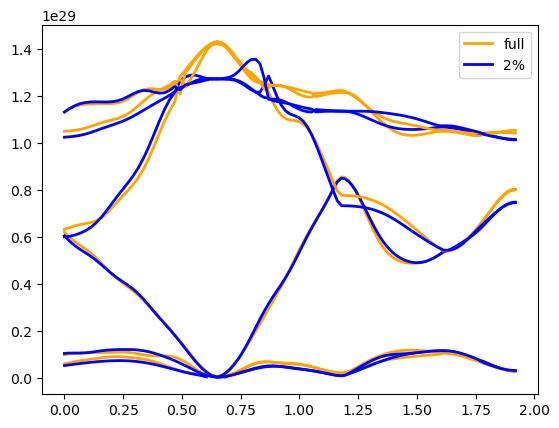

In [ ]:
import numpy as np
import scipy
from scipy.constants import physical_constants, hbar

atomic_mass = physical_constants["atomic mass constant"][0]

POMASS = 28.085
mass = 2 * POMASS * atomic_mass   # kg, adjust if unit cell has different number of atoms

# make sure w is in THz
we = w * 2.0 * np.pi * 1e12   # rad/s
we2 = w * 2.0 * np.pi * 1e12   # rad/s
g2_full = 2.0 * np.sum(np.abs(g_bloch_full[0])**2, axis=(-2, -1)) / nbnd   # already did 2/Nb
g2_2perc = 2.0 * np.sum(np.abs(g_bloch_2perc[0])**2, axis=(-2, -1)) / nbnd

# convert g^2 from (Ry)^2 to J^2

# according to eq. (9): D = (1/ħ) * sqrt( 2 ω M_uc * (1/Nb) * sum |g|^2 )
# here g2_full_J2 already contains the 2/Nb factor, so:
sqrt_full = np.sqrt(mass * we * g2_full)   # sqrt(2 ω M_uc * sum|g|^2 / Nb)
sqrt_2perc = np.sqrt(mass * we * g2_2perc)

D = sqrt_full / hbar    # now divide by ħ outside the sqrt
D_2perc = sqrt_2perc / hbar

# convert from J/m to eV/Å if the quantity is J/m — check units:
# after the algebra above D should be in units of J/m, so convert:
D = D 
D_2perc = D_2perc 

# plot
plt.figure()
plt.plot(x_axis, D[:, 0], label="full", color="orange",linewidth=2)
plt.plot(x_axis, D_2perc[:, 0], label="2%",color ="blue", linewidth=2)
for v in range(1, nmodes):
    plt.plot(x_axis, D[:, v], color="orange", linewidth=2)
    plt.plot(x_axis, D_2perc[:, v],color ="blue", linewidth=2)
plt.legend()
plt.show()


/var/folders/gr/lkj_28r53q1683rgp_t8jfhw0000gn/T/ipykernel_58574/3394864607.py:25: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(prefactor * g2_full_J) * J_per_m_to_eV_per_A
/var/folders/gr/lkj_28r53q1683rgp_t8jfhw0000gn/T/ipykernel_58574/3394864607.py:26: RuntimeWarning: invalid value encountered in sqrt
  D_2perc = np.sqrt(prefactor * g2_2perc_J) * J_per_m_to_eV_per_A


(117, 6)


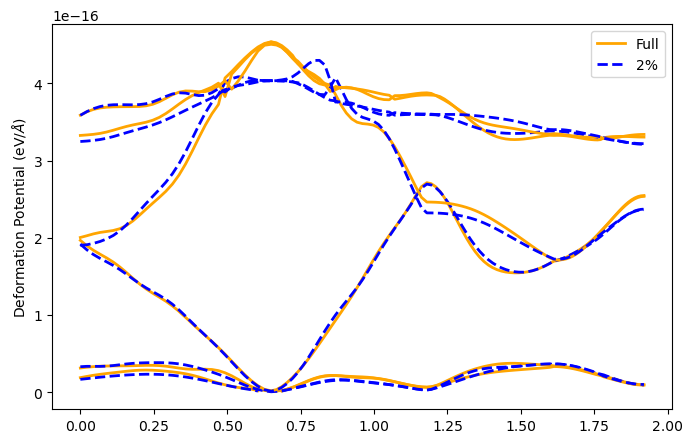

In [341]:
import scipy
from scipy.constants import physical_constants
atomic_mass = physical_constants["atomic mass constant"][0]
POMASS = 28.085
mass = 2*POMASS * atomic_mass

# 1. Define conversion factors
Ry_to_J = physical_constants["Rydberg constant times hc in J"][0]
J_per_m_to_eV_per_A = 1 / (scipy.constants.e * 1e10)

# 2. Prepare inputs in SI units (Joules, seconds, radians)
# w is originally in THz. Convert to angular frequency (rad/s)
w_si = w * 1e12 * 2 * np.pi 

# 3. Calculate |g|^2 in Joules^2
# Your 'sum' is in Ry^2. We convert to J^2.
g2_full_J = sum * (Ry_to_J**2)
g2_2perc_J = sum_2perc * (Ry_to_J**2)

# 4. Calculate D (Deformation Potential)
# Formula: D = sqrt( 2 * M * w * |g|^2 / hbar )
# Result is in J/m. We multiply by conversion factor to get eV/A.
prefactor = 2 * mass * w_si / scipy.constants.hbar

D = np.sqrt(prefactor * g2_full_J) * J_per_m_to_eV_per_A
D_2perc = np.sqrt(prefactor * g2_2perc_J) * J_per_m_to_eV_per_A

print(D.shape)

plt.figure(figsize=(8,5))
# Plot Optical Modes (indices 3,4,5 for Silicon)
for v in range( nmodes):
    plt.plot(x_axis, D[:, v], color="orange", linewidth=2, label="Full" if v==3 else "")
    plt.plot(x_axis, D_2perc[:, v], color="blue", linewidth=2, linestyle="--", label="2%" if v==3 else "")

plt.ylabel(r"Deformation Potential (eV/$\AA$)")
plt.legend()
plt.show()